In [6]:
import pandas as pd
import numpy as np
import scipy
import datetime
import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

**Данные о просмотрах каналов**

In [7]:
df = pd.read_csv('dataset11-30.csv')
df.start_time = pd.to_datetime(df.start_time)
df.stop_time = pd.to_datetime(df.stop_time)
df['date'] = df['start_time'].dt.date

**Данные о расписании ТВ-передач**

In [8]:
df_info = pd.read_csv('export_arh_11-20-final.csv').append(pd.read_csv('export_arh_21-30-final.csv'))
df_info.start_time = pd.to_datetime(df_info.start_time, format='%d.%m.%Y %H:%M:%S')
df_info['stop_time'] = df_info['start_time'] + pd.to_timedelta(df_info['duration'], unit='s')
df_info = df_info[df_info.tv_show_id != 0].copy()

**Оценка данных**

In [9]:
print('Количество пользователей:', df.user_id.nunique())
print('Количество каналов:', df.vsetv_id.nunique())
print('Количество ТВ программ:', df_info.tv_show_id.nunique())
print('Даты данных:', df.start_time.min(), df.start_time.max())
print('Даты данных info:', df_info.start_time.min(), df_info.start_time.max())

Количество пользователей: 4914
Количество каналов: 202
Количество ТВ программ: 8234
Даты данных: 2020-03-09 00:00:02 2020-07-26 23:58:42
Даты данных info: 2020-03-08 23:00:00 2020-07-27 06:00:00


**Количество данных по дням**

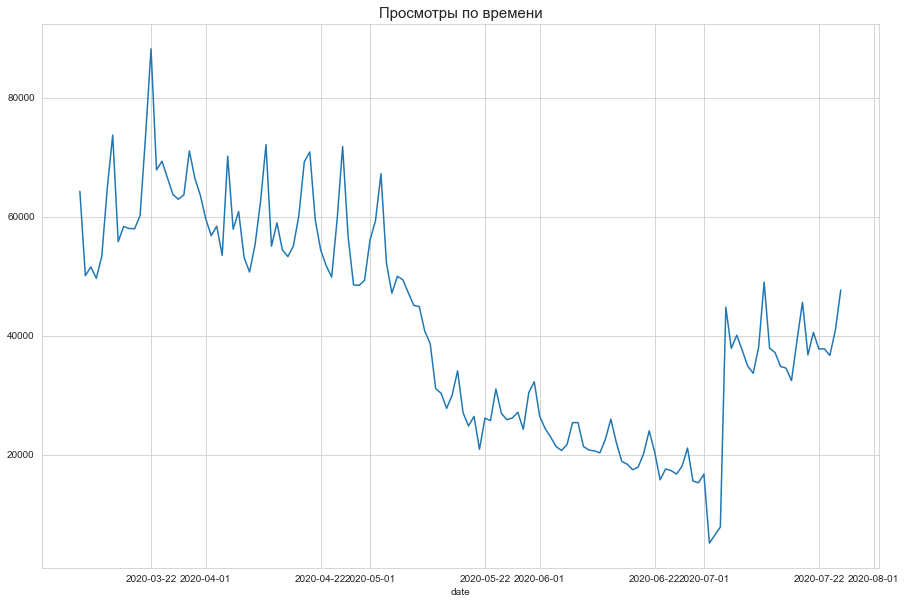

In [10]:
ax = df.groupby(['date']).size().plot(figsize = (15, 10));
ax.set_title('Просмотры по времени', fontsize = 15);

**В названиях тв-передач много признаков- кино / нет, сезон, серия, премьера.**

In [13]:
for c in ['эп.', 'м/с', 'х/ф', 'д/ф', 'м/ф', 'т/с', 'премьера']:
    c_index = df_info[df_info['tv_show_title'].str.lower().str.contains(c)].index

for c in ['c.', 'c..']:
    c_index = df_info[df_info['tv_show_title'].str.lower()==c].index

**Есть перерывы между передачами**

**Есть дубликаты по channel_id, нужно чистить**

In [14]:
channel_info_df = df_info[['channel_id', 'channel_title']].drop_duplicates()
channel_info_df[channel_info_df.duplicated(['channel_id'], keep = False)].sort_values(['channel_id'])

,channel_id,channel_title
91075,75,Киев
91522,75,Київ
198043,288,Русский экстрим
200295,288,Russian Extreme (HD REX)
985795,1249,UA:Перший (спутник)
980933,1249,UA:Перший


**Есть дубликаты по инфо, нужно чистить**

In [16]:
show_info_df = df_info[['tv_show_id', 'tv_show_category', 'tv_show_genre_1', 
                        'tv_show_genre_2', 'tv_show_genre_3', 'year_of_production', 
                        'director', 'actors']].drop_duplicates()
show_info_df[show_info_df.duplicated(['tv_show_id'], keep = False)].sort_values(['tv_show_id']).head(3)

,tv_show_id,tv_show_category,tv_show_genre_1,tv_show_genre_2,tv_show_genre_3,year_of_production,director,actors
989799,900954,Фильмы,драма,криминал,NaN,1995,Тим Роббинс,"Сюзан Сарандон, Шон Пенн, Роберт Проски"
748493,900954,Фильмы,драма,NaN,NaN,1995,Тим Роббинс,"Сюзан Сарандон, Шон Пенн, Роберт Проски"
832602,2000444,Спорт,спорт,хоккей,NaN,2018-2018,NaN,NaN


**Есть дубликаты времени просмотра - когда видимо неполностью запускают кино / серию, когда есть интервенции**

In [17]:
show_duration_df = df_info[['tv_show_id', 'duration']].drop_duplicates()
show_duration_df[show_duration_df.duplicated(['tv_show_id'], keep = False)].sort_values(['tv_show_id']).head(3)

,tv_show_id,duration
186401,20088,10500
10,20088,1800
12,20088,3000


**Топ каналы по передачам**

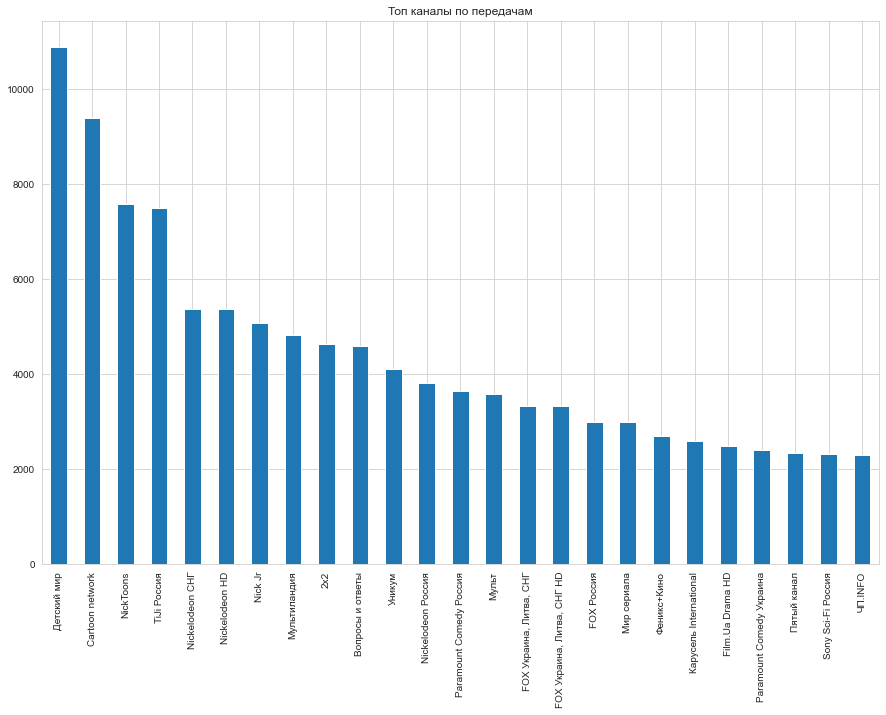

In [19]:
ax = df_info['channel_title'].value_counts()[:25].plot(figsize = (15, 10), kind = 'bar');
ax.set_title('Топ каналы по передачам');

**Tv_show_id - не показывает серию, а только программу в целом**

In [20]:
tv_show_id_df = df_info[['tv_show_id', 'tv_show_title']].drop_duplicates()
tv_show_id_df[tv_show_id_df.duplicated(['tv_show_id'], keep = False)].sort_values(['tv_show_id']).head()

,tv_show_id,tv_show_title
16761,30066,"'Наша Russia'. Дайджест, 1 эп."
16776,30066,"'Наша Russia'. Дайджест, 16 эп."
16775,30066,"'Наша Russia'. Дайджест, 15 эп."
16774,30066,"'Наша Russia'. Дайджест, 14 эп."
16773,30066,"'Наша Russia'. Дайджест, 13 эп."
